## Fake and real news dataset

https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset

In [198]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [199]:
fake = pd.read_csv('Fake.csv')
true = pd.read_csv('True.csv')

In [200]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [201]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [202]:
fake['target'] = 'fake'
true['target'] = 'true'

Add flag to track fake and real

In [203]:
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

Concatenate dataframes

In [204]:
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

Shuffle the data

In [205]:
data.drop(["date"],axis=1,inplace=True)
data.drop(["title"],axis=1,inplace=True)

Removing the date and title column (we won't use it for the analysis)

In [206]:
import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

Removing punctuation. Here i'm using  Pandas method: apply() - to change fragment of the dataframe.

In [207]:
data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,washington reuters senate majority leader mit...,politicsNews,true
1,cnn has once again set the stage for a democra...,Government News,fake
2,washington reuters us senator marco rubio sai...,politicsNews,true
3,hong kong reuters three judges in hong kong s...,worldnews,true
4,london reuters british prime minister theresa...,worldnews,true


Here i'm converting our data['text'] to lowercase, because some text are uppercase letters

In [208]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\homen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


 Removing stopwords (such as “the”, “a”, “an”, “in”). We would not want these words to take up space in our database, or taking up valuable processing time. 

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


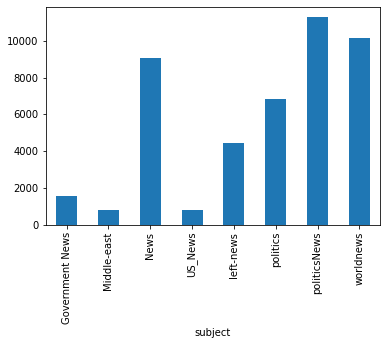

In [209]:
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

Here showed how many articles per subject in dataset

target
fake    23481
true    21417
Name: text, dtype: int64


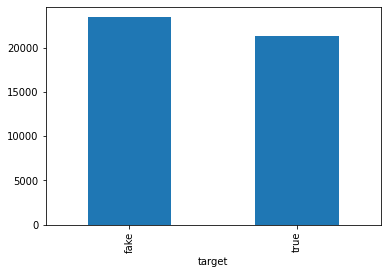

In [210]:
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

Here showed how many fake and real articles in dataset

In [211]:
from nltk import tokenize
import seaborn as sns

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

The function which find most frequent words used in text.

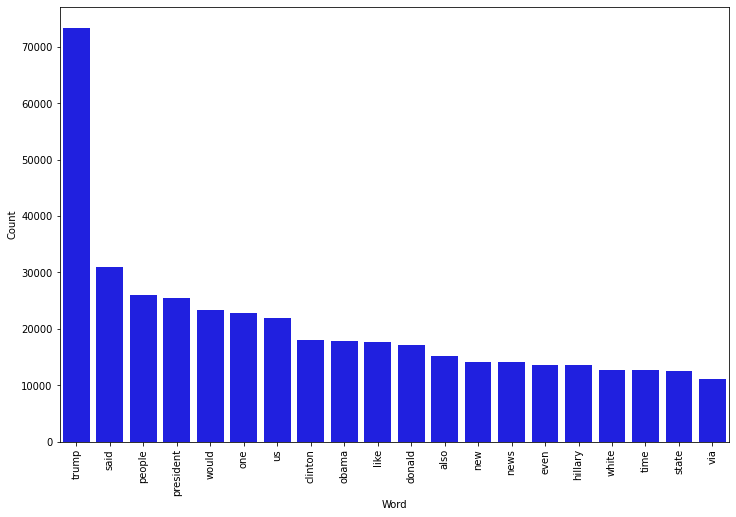

In [212]:
counter(data[data["target"] == "fake"], "text", 20)

On the graph above shows the most frequent words in fake news

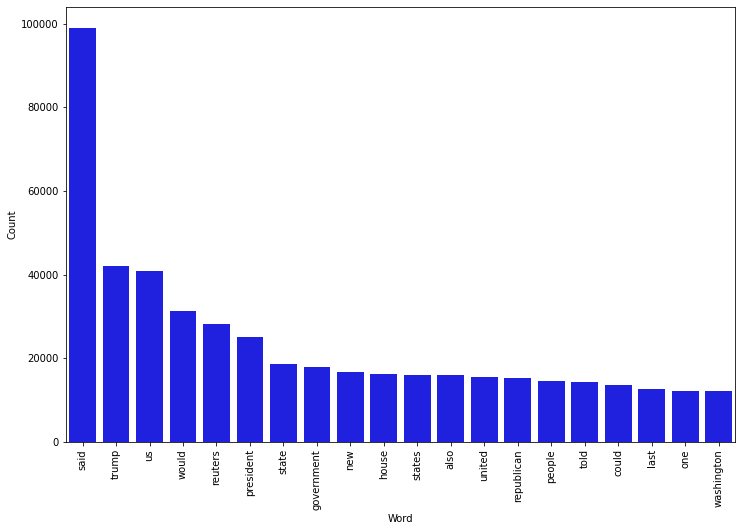

In [213]:
counter(data[data["target"] == "true"], "text", 20)

On the graph above shows the most frequent words in real news


As we can see from the above graphs, some words like 'trump', 'would' etc., are used in both cases: fake news and real news. But in one case they are more common, in other less common.

In [214]:
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

Here I spilt the data into X_train, X_test, y_train, y_test with the test_size of the original data 20%

In [215]:
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

 Function to plot the confusion matrix 


### Trying different modelling technique to get better prediction

LOGISTIC REGRESSION

In [216]:
%%time
from sklearn.linear_model import LogisticRegression

# Vectorizing and applying TF-IDF(term frequency-inverse document frequency)
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model_1', LogisticRegression())])

model_1 = pipe.fit(X_train, y_train)

prediction = model_1.predict(X_test)
print("Accuracy using Logistic Regression: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

Accuracy using Logistic Regression: 98.84%
Wall time: 16 s


Confusion matrix, without normalization


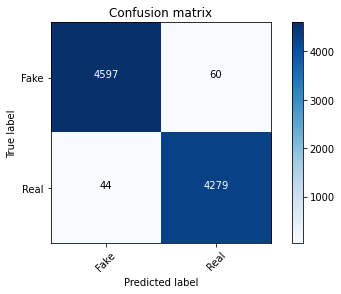

In [217]:
model1_cm=metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(model1_cm, classes=['Fake', 'Real'])

Training my model by LogisticRegression with training data (after transformation by CountVectorizer and TF-IDF).\
Confusion matrix: \
4579 cases - We predicted fake news and that's fake news.\
44 cases   -   We predicted real news, but that's actually fake news.\
60 cases - We predicted fake news, but that's actually real news.\
4279 cases - We predicted real news and that's real news.

RANDOM FOREST CLASSIFIER

In [218]:
%%time
from sklearn.ensemble import RandomForestClassifier

# Vectorizing and applying TF-IDF(term frequency-inverse document frequency)
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model_2', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model_2 = pipe.fit(X_train, y_train)

prediction = model_2.predict(X_test)
print("Accuracy using Random Forest Classifier: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

Accuracy using Random Forest Classifier: 99.02%
Wall time: 1min 3s


Confusion matrix, without normalization


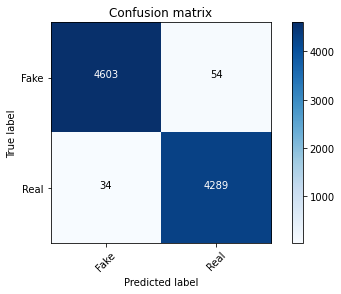

In [219]:
model2_cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(model2_cm, classes=['Fake', 'Real'])

Training my model by RandomForestClassifier(with a number of trees = 50) with training data (after transformation by CountVectorizer and TF-IDF).\
Confusion matrix: \
4603 cases - We predicted fake news and that's fake news.\
34 cases   -   We predicted real news, but that's actually fake news.\
54 cases - We predicted fake news, but that's actually real news.\
4289 cases - We predicted real news and that's real news.

DECISION TREE CLASSIFIER

In [220]:
%%time
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF(term frequency-inverse document frequency)
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model_3', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
model_3 = pipe.fit(X_train, y_train)

prediction = model_3.predict(X_test)
print("Accuracy using Decision Tree Classifier: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

Accuracy using Decision Tree Classifier: 99.6%
Wall time: 31.9 s


Confusion matrix, without normalization


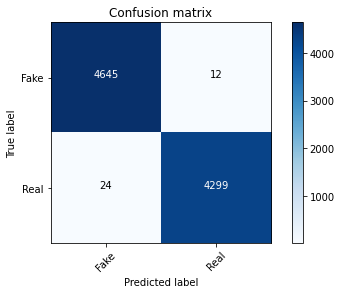

In [221]:
model3_cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(model3_cm, classes=['Fake', 'Real'])

Training my model by DecisionTreeClassifier(with the maximum depth of the tree = 20) with training data (after transformation by CountVectorizer and TF-IDF).\
Confusion matrix: \
4645 cases - We predicted fake news and that's fake news.\
24 cases   -   We predicted real news, but that's actually fake news.\
12 cases - We predicted fake news, but that's actually real news.\
4299 cases - We predicted real news and that's real news.

As we can see predict test data is very similar to real test data. First model technique took less time than the second and the third one, but have the smallest accuracy score. The second model technique take the longest time, and have better accuracy than the first one, but worse than the third one. The most optimal classifier in this case is "Decision tree classifier", because this technique take average time between another two model techniques and have the best accuracy score.

The accuracy difference between "RANDOM FOREST CLASSIFIER" and "LOGISTIC REGRESSION" is almost 0.2 %, between "LOGISTIC REGRESSION" and "DECISION TREE CLASSIFIER" is almsot 0.8% for the testing set. If we look on confusion matrix we can see the clearly difference between accuracy in a numbers.